# Weather Station Data - cleaned final version 
## Level 1 QC

In [76]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1

In [77]:
#Do you want to display plots (slow for large datasets)
show_plots=True #True= show plots
frac=0.1 #fraction of data to show in plots (0.3 = 30%)

** Define Location-Specific Baseline Settings **

In [78]:
#path to level 0 data
Glacier="Gulkana" #or "Gulkana"
Station="1725" #or other elevations; this depends on the naming convention of input data
file_label='_15min'
yr='all' #either "all" or the year you want
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/" + Glacier.lower()+ Station+ file_label+"_"+yr+".csv"

# if Glacier + Station=='Gulkana1725':
#     print("MAKE SURE TO RUN Gulkana1725 FillGapsWithIrridicum.py; this station has telemetered data. This is called in L0")
#     pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/" + Glacier.lower()+ Station+ file_label+"_"+yr+"_gaps_filled.csv"
    
#time format and column
UTC_time_column_name='UTC_time'
local_time_column_name='local_time'
date_format='%Y/%m/%d %H:%M'
timezone='America/Anchorage' #choose from pytz.all_timezones

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+Station+file_label+yr+".csv"

#Names of columns containing precipitation data
precip_columns=['TPGCumulative', 'StageCumulative']

### Data import
- read in data 
- set timezone
- set time as index

In [92]:
#read in level0 CSV
if Glacier +Station == "Gulkana1725":
    pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/Gulkana/AllYears/Wx/LVL0/emily/gulkana1725_15min_all_gaps_filled.csv"

dat=pd.read_csv(pth)
print("read data from: "+ pth)

#Set local time to dataframe index
dat['local_time']=pd.to_datetime(dat[local_time_column_name], format=date_format)
dat=dat.set_index('local_time')
dat=dat.tz_localize(timezone, ambiguous='infer')

read data from: Q:/Project Data/GlacierData/Benchmark_Program/Data/Gulkana/AllYears/Wx/LVL0/emily/gulkana1725_15min_all_gaps_filled.csv


Station-specific Data Adjustments

In [93]:
# Wolverine990 and Gulkana 1480: Prior to April 2014, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    
if Glacier+Station=="Gulkana1480":
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan

In [94]:
#Time subset for trouble-shooting
# dat=dat['2016':]
# for precip_col in precip_columns:
#     dat[precip_col]=dat[precip_col]-dat[precip_col][0]

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [95]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.xlsx"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed:")
bad_sensor_dates_dat

Removed:


,Sensor,Start_Date,End_Date,Action,Correct_Label,Location,Comment
0,TPGCumulative,2015-09-24 17:00:00,2015-09-26 12:00:00,bad,NaN,Gulkana1725,none at Gulkana 1725


** Set hard-coded cutoff values** (station specific)

In [96]:
if (Glacier+Station=="Wolverine990"):
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 *1000.#meters
    precip_drain_cutoff=-0.015 *1000.
    obvious_error_precip_cutoff=0.20 *1000. #if 20 cm in 15 minutes, obviously an error. (7/2016 has a drain of only 24 cm)
    
    noise_limit=0.0025 *1000.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed
    
if Glacier + Station== "Gulkana1480":
    low_temp_cutoff=-40
    high_temp_cutoff=30

    precip_high_cutoff=0.015 *1000#in meters
    precip_drain_cutoff=-0.015 *1000
    obvious_error_precip_cutoff=0.15 *1000#if 15 cm in 15 minutes, obviously an error.
    noise_limit=0.0025 *1000
    
    Stage_dies='2015/09/25 11:30:00' #time at which instrument was removed
    TPG_born='2011/07/15 18:30:00' #time at which instrument was removed
    
if (Glacier + Station== "Gulkana1725"):
    low_temp_cutoff=-40
    high_temp_cutoff=30

    precip_high_cutoff=0.015 *1000#in meters
    precip_drain_cutoff=-0.015 *1000
    obvious_error_precip_cutoff=0.15 *1000#if 15 cm in 15 minutes, obviously an error.
    noise_limit=0.0025 *1000
    
    TPG_born='2014-08-26 16:00:00'
    
if (Glacier + Station== "Wolverine1420") | (Glacier+Station=="Gulkana1920") : #these are the 2 ridgetop JWS sites
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 *1000.#meters
    precip_drain_cutoff=-0.015 *1000.
    obvious_error_precip_cutoff=0.20 *1000. #if 20 cm in 15 minutes, obviously an error. (7/2016 has a drain of only 24 cm)
    
    noise_limit=0.0025 *1000.
    

In [97]:
#Convert units in precipitation columns from meters to mm
for precip_col in precip_columns:
    dat.loc[:,precip_col]=dat[precip_col]*1000

In [98]:
#Set gages to NAN, when not installed (single gauge style does not cover period of record)
for precip_col in precip_columns:
    if dat[precip_col].isnull().all():
        print("no data in "+ precip_col)
        continue
    if 'TPG' in precip_col.upper(): #this is the current precip gage
        dat.loc[:TPG_born, precip_col]=np.nan
        dat.loc[TPG_born:, precip_col]=dat.loc[TPG_born:, precip_col].interpolate(method='linear', limit=400) #fill short gaps in record, < 2days
    if 'stage' in precip_col.lower(): #this is old precip gage
        dat.loc[Stage_dies:, precip_col]=np.nan
        dat.loc[:Stage_dies, precip_col]=dat.loc[:Stage_dies, precip_col].interpolate(method='linear', limit=400) #fill short gaps in record, <2 days

no data in StageCumulative


In [99]:
#Save unaltered data for later comparrison with edits
dat_original=dat.copy()

** Clean Temperature Data**

In [100]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

#### Plot temperature data, before and after

<IPython.core.display.Javascript object>


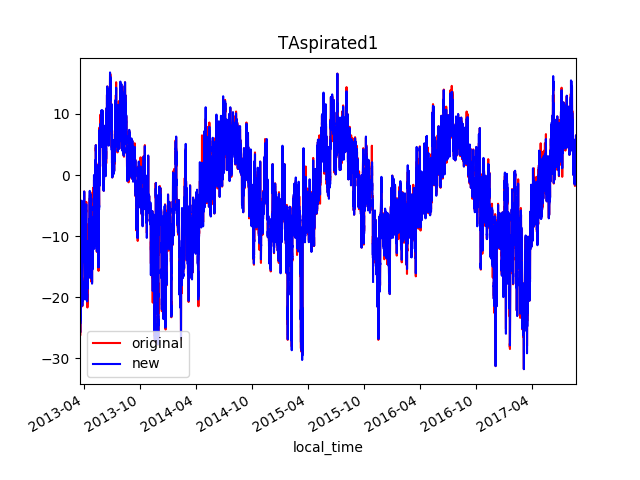

In [88]:
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original.sample(frac=0.2), df_new=dat.sample(frac=0.2), data_col_name='TAspirated1')

#### Clean Wind Direction Data

In [101]:
wind_dir_columns=['WindDir', 'VecAvgWindDir']
for col in wind_dir_columns:
    dat.loc[dat[col]>360, col]=np.nan #Nonsensical; at wolverine990, this is only 3 days; results from mis-pogramming of logger

** Plot original precipitation data**

<IPython.core.display.Javascript object>


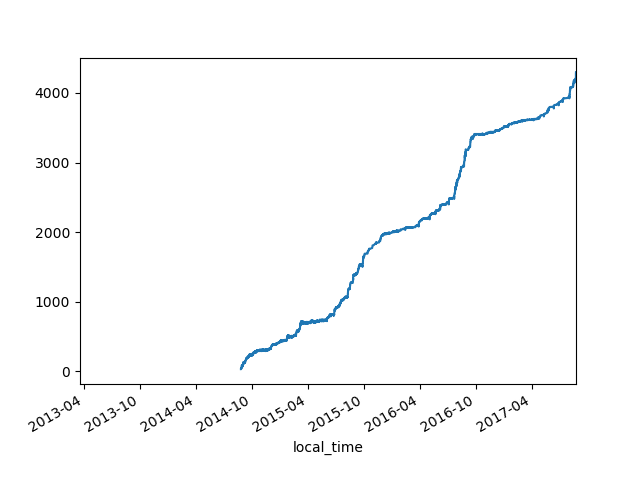

In [102]:
#Precip
%matplotlib notebook
if show_plots and not dat_original[precip_columns[0]].isnull().all():
    dat_original[precip_columns[0]].plot()

** Remove Gauge Drain and Fill Maintenance **

In [104]:
#Remove unrealistically large instantaneous jumps; create continuous timreseries
for precip_col in precip_columns:
    if dat[precip_col].isnull().all():
        print("no data in "+ precip_col)
        continue    
    print(precip_col)
    if dat[precip_col].isnull().all(): #if no values in column, skip
        continue
    dat.loc[:,precip_col]=LVL1.precip_remove_drain_and_fill(dat_original[precip_col], obvious_error_precip_cutoff=obvious_error_precip_cutoff, n_cut=4)
dat_step0=dat[precip_columns].copy() #save for plotting

TPGCumulative
no data in StageCumulative


<IPython.core.display.Javascript object>


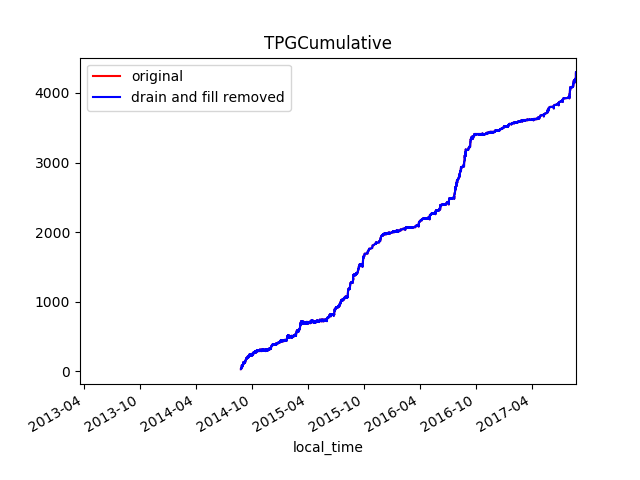

In [105]:
#Plot
if not dat[precip_columns[0]].isnull().all() and show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[0], label_old="original", label_new="drain and fill removed")

In [106]:
#Plot older precip gage
if not dat[precip_columns[1]].isnull().all() and show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[1], label_old="original", label_new="drain and fill removed")

In [107]:
#Fill any remaining gaps due to sensor fallout, etc: 
# for precip_col in precip_columns:
#     dat_step0.loc[:,precip_col]=LVL1.precip_interpolate_gaps_under1day(dat_step0[precip_col])

#### Remove high-amplitude noise related to wind

In [108]:
#Remove high-amplitude noise, related to wind, etc.
imp.reload(LVL1)
for precip_col in precip_columns:
    if dat[precip_col].isnull().all(): #if no values in column, skip
        continue
    print(precip_col)
    dat.loc[:, precip_col]=LVL1.precip_remove_high_frequency_noiseNayak2010(dat_step0[precip_col], noise=noise_limit, bucket_fill_drain_cutoff=obvious_error_precip_cutoff, n_forward_noise_free=10)
dat_step1=dat[precip_columns].copy() #save for plotting

TPGCumulative
noise starts at 2014-08-27 09:45:00-08:00 ; 50820
noise starts at 2014-08-27 18:30:00-08:00 ; 50855
noise starts at 2014-08-28 17:30:00-08:00 ; 50947
noise starts at 2014-08-28 23:30:00-08:00 ; 50971
noise starts at 2014-08-29 03:00:00-08:00 ; 50985
noise starts at 2014-08-29 15:30:00-08:00 ; 51035
noise starts at 2014-08-30 06:45:00-08:00 ; 51096
noise starts at 2014-08-30 20:45:00-08:00 ; 51152
noise starts at 2014-08-31 08:45:00-08:00 ; 51200
noise starts at 2014-08-31 13:45:00-08:00 ; 51220
noise starts at 2014-09-01 08:00:00-08:00 ; 51293
noise starts at 2014-09-02 07:45:00-08:00 ; 51388
noise starts at 2014-09-02 21:00:00-08:00 ; 51441
noise starts at 2014-09-03 02:45:00-08:00 ; 51464
noise starts at 2014-09-03 08:45:00-08:00 ; 51488
noise starts at 2014-09-03 16:00:00-08:00 ; 51517
noise starts at 2014-09-04 01:45:00-08:00 ; 51556
noise starts at 2014-09-04 16:30:00-08:00 ; 51615
noise starts at 2014-09-05 16:00:00-08:00 ; 51709
noise starts at 2014-09-06 10:00:00-

<IPython.core.display.Javascript object>


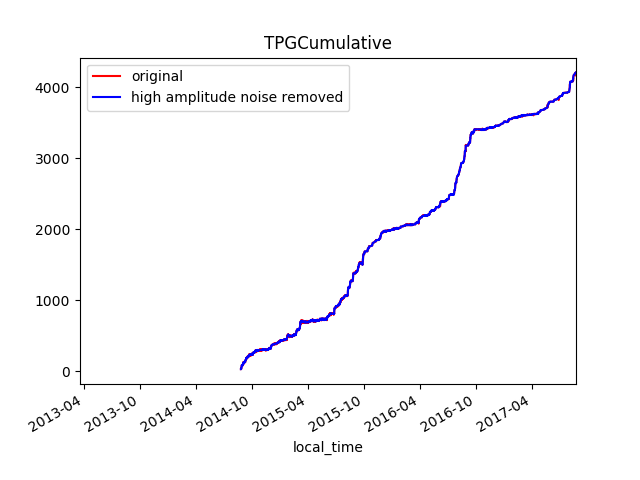

In [109]:
#Plot results
if show_plots and not dat_original[precip_columns[0]].isnull().all():
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step0.sample(frac=0.3), df_new=dat_step1.sample(frac=0.3), data_col_name=precip_columns[0], label_old="original", label_new="high amplitude noise removed")

In [110]:
#Strip Remaining Outlier Values with Hampel Filter
for precip_col in precip_columns:
    if dat[precip_col].isnull().all():
        continue
    dat.loc[:,precip_col]=LVL1.hampel(dat_step1[precip_col])
dat_step2=dat[precip_columns].copy() #save for plotting

<IPython.core.display.Javascript object>


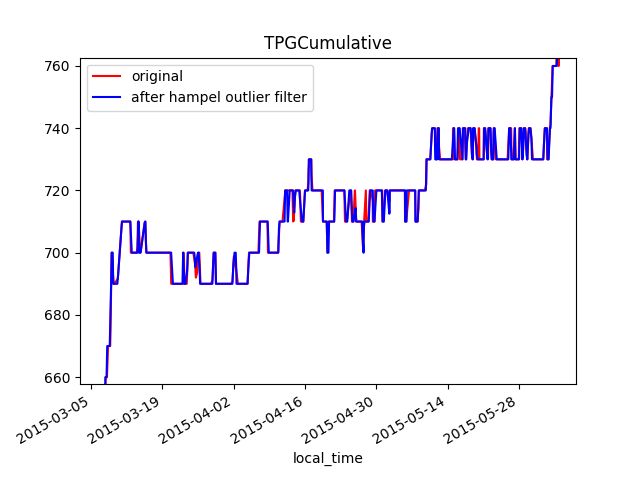

In [111]:
#Plot results
if show_plots and not dat_original[precip_columns[0]].isnull().all():
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step1.sample(frac=frac), df_new=dat_step2.sample(frac=frac), data_col_name=precip_columns[0], label_old="original", label_new="after hampel outlier filter")

In [112]:
#Interpolate gaps under one day in length
# for precip_col in precip_columns:
#     dat[precip_col]=LVL1.precip_interpolate_gaps_under1day(dat_step2[precip_col])

**Smooth Data with method from Nayak (2010): **

In [113]:
#Smooth Incremental Precip Data
for precip_col in precip_columns:
    #Smooth this data with method from Nayak 2010
    if dat[precip_col].isnull().all(): #if no values in column, skip
        continue
    print ("smoothing "+ precip_col)
    dat[precip_col]=LVL1.smooth_precip_Nayak2010(dat_step2[precip_col])
dat_step3=dat[precip_columns].copy() #save for plotting

smoothing TPGCumulative
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute


<IPython.core.display.Javascript object>


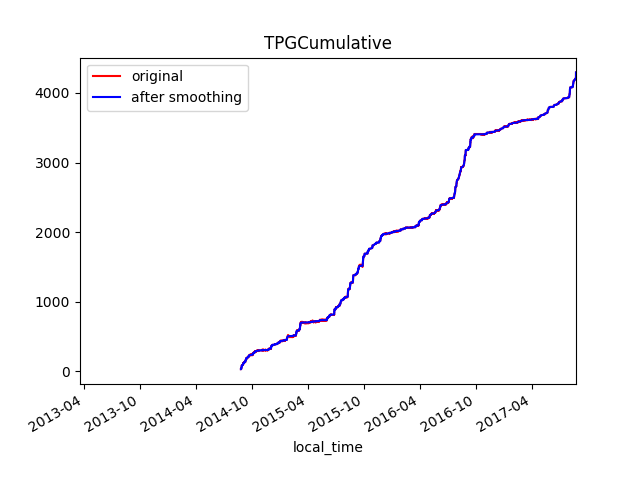

In [114]:
#Plot
if show_plots and not dat_original[precip_columns[0]].isnull().all():
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step2, df_new=dat_step3, data_col_name=precip_columns[0], label_old="original", label_new="after smoothing")

In [116]:
if show_plots and not dat_original[precip_columns[1]].isnull().all():
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step2.sample(frac=frac), df_new=dat_step3.sample(frac=frac), data_col_name=precip_columns[1], label_old="original", label_new="after smoothing")

<IPython.core.display.Javascript object>


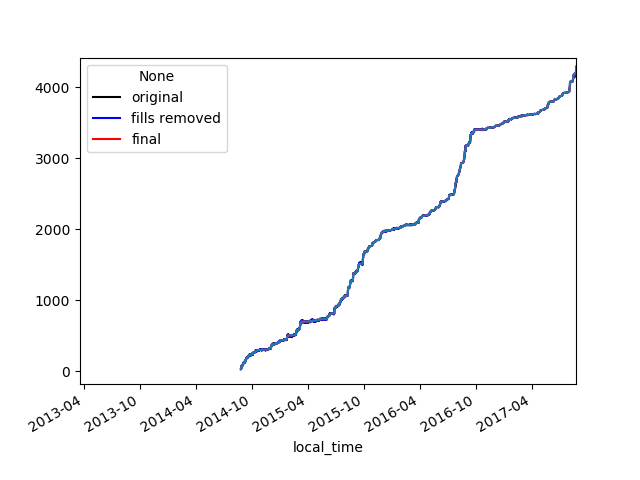

In [117]:
#Final Comparrison Plot
if show_plots and not dat_original[precip_columns[0]].isnull().all():
    %matplotlib notebook
    frac=0.1
    ax=dat_original[precip_columns[0]].sample(frac=frac).plot(color='black', label='original')
    dat_step0[precip_columns[0]].sample(frac=frac).plot(color='blue', ax=ax, label='fills removed')
    dat_step3[precip_columns[0]].sample(frac=frac).plot(color='red', ax=ax, label='final')
    plt.legend()

Final Steps

In [118]:
#Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
for precip_col in precip_columns:
    if dat[precip_col].isnull().all(): #if no values in column, skip
        continue
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [119]:
#Create time as text column
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+precip_columns+wind_dir_columns+['WindSpeed', 'WindGustSpeed','RelHum', 'RadiationIn', 'RadiationOut', 'SnowDepth', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')
#save_dat.to_csv(index=False, float_format='%g')


<IPython.core.display.Javascript object>


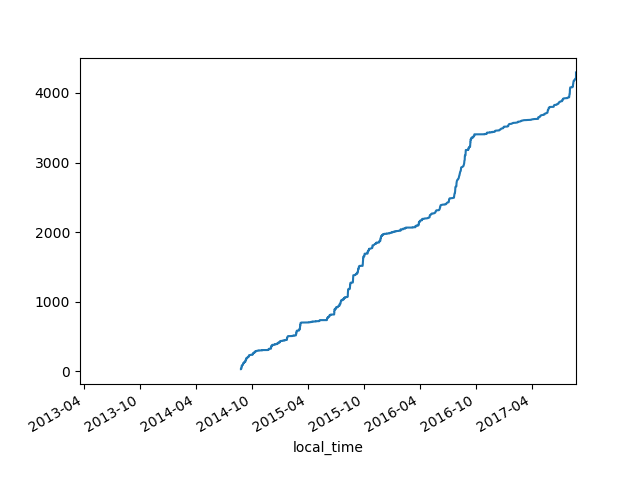

In [121]:
%matplotlib notebook
save_dat.TPGCumulative.plot()

<IPython.core.display.Javascript object>


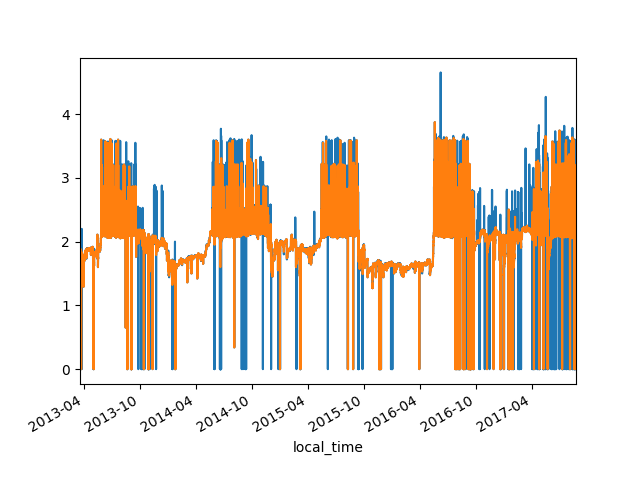

In [127]:
%matplotlib notebook
ax=dat.SnowDepth.plot()
outSD.plot(ax=ax)

In [125]:
outSD=LVL1.hampel(dat.SnowDepth)

In [130]:
save_dat.SnowDepth.tail(30)

local_time
2017-08-22 21:45:00-08:00    2.088
2017-08-22 22:00:00-08:00    3.344
2017-08-22 22:15:00-08:00    2.093
2017-08-22 22:30:00-08:00    2.303
2017-08-22 22:45:00-08:00    2.093
2017-08-22 23:00:00-08:00    2.482
2017-08-22 23:15:00-08:00    2.126
2017-08-22 23:30:00-08:00    2.151
2017-08-22 23:45:00-08:00    2.499
2017-08-23 00:00:00-08:00    2.155
2017-08-23 00:15:00-08:00    2.483
2017-08-23 00:30:00-08:00    3.169
2017-08-23 00:45:00-08:00    2.091
2017-08-23 01:00:00-08:00    2.095
2017-08-23 01:15:00-08:00    2.466
2017-08-23 01:30:00-08:00    2.091
2017-08-23 01:45:00-08:00    2.093
2017-08-23 02:00:00-08:00    2.477
2017-08-23 02:15:00-08:00    2.084
2017-08-23 02:30:00-08:00    2.484
2017-08-23 02:45:00-08:00    2.487
2017-08-23 03:00:00-08:00    2.491
2017-08-23 03:15:00-08:00    2.491
2017-08-23 03:30:00-08:00    2.156
2017-08-23 03:45:00-08:00    2.500
2017-08-23 04:00:00-08:00    2.143
2017-08-23 04:15:00-08:00    2.154
2017-08-23 04:30:00-08:00    2.150
2017-08-2